<a href="https://www.kaggle.com/code/andriybabiy/02-image-classification-intel-image-classification?scriptVersionId=199913640" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 02_Image_Classification
Using the Intel Image Classification dataset, my goal is to develop and train a deep learining model that will attempt to correctly classify the images.

In [1]:
import os
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tempfile import TemporaryDirectory

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
import torchvision.transforms as T
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.utils import make_grid

from sklearn.metrics import confusion_matrix, f1_score, balanced_accuracy_score, classification_report

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

torch.cuda.empty_cache()

import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

plt.ion() # interactive mode

import warnings
# filter warnings
warnings.filterwarnings('ignore')

In [2]:
resize_size = (224, 224)

# transform_train = transforms.Compose([
#     transforms.Resize(resize_size),
#     transforms.RandomCrop(size=(150, 150)),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# transform = transforms.Compose([
#     transforms.Resize(resize_size),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(resize_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(resize_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(resize_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

## Download and prepare the data for processing

In [3]:
# Kaggle
path_to_dir = '/kaggle/input/intel-image-classification'

pred = '/kaggle/input/intel-image-classification/seg_pred'
test = '/kaggle/input/intel-image-classification/seg_test/seg_test'
train = '/kaggle/input/intel-image-classification/seg_train/seg_train'

path_to_model = '/kaggle/working/'
model_filename = 'baseline_model.pth'
path_to_model_file = os.path.join(path_to_model, model_filename)

# deleting the existing model if exists (optional - if needed to restart from scratch)
# if os.path.exists(path_to_model_file):
#     os.remove(path_to_model_file)
#     print(f"Existing Model '{model_filename}' has been deleted.")
# else:
#     print(f"No existing model file '{model_filename}' found.")

# torch.save(model.state_dict(), path_to_model_file)
path_to_model_file

'/kaggle/working/baseline_model.pth'

In [4]:
image_datasets = {x: datasets.ImageFolder(os.path.join(path_to_dir, 'seg_' + x, 'seg_' + x), data_transforms[x]) for x in ['train', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4) for x in ['train', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

class_names = image_datasets['train'].classes

print(dataset_sizes)
print(class_names)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

{'train': 14034, 'test': 3000}
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [5]:
# inputs, labels = next(iter(dataloaders['train']))
# print("Batch shape:", inputs.shape) 

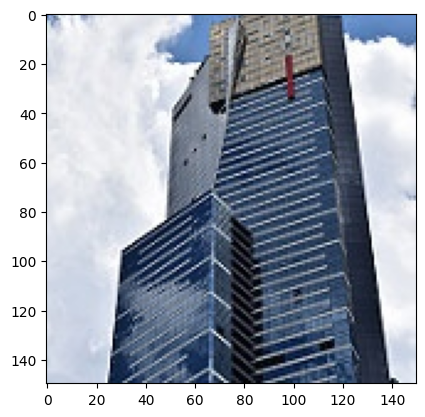

In [6]:
im = Image.open('/kaggle/input/intel-image-classification/seg_test/seg_test/buildings/20057.jpg')
plt.imshow(im)
plt.show() # image will not be displayed without this

### Transformations

In [7]:
# class ImageDataset(Dataset):
#     def __init__(self, data_dir, transform):
#         self.data_dir = data_dir
#         self.transform = transform
#         self.filenames = []
#         self.labels = []
#         self.class_names = []
        
#         # Traverse the directory structure
#         for root, dirs, files in os.walk(data_dir):
#             # Get the class name based on the folder name
#             class_name = os.path.basename(root)
            
#             if len(files) > 0:
#                 # Append all file paths and assign labels based on folder name
#                 for filename in files:
#                     if filename.endswith('.jpg'):
#                         self.filenames.append(os.path.join(root, filename))
#                         # Use the class name (parent folder name) as the label
#                         if class_name not in self.class_names:
#                             self.class_names.append(class_name)
#                         label = self.class_names.index(class_name)
#                         self.labels.append(label)
                        
#     def __len__(self):
#         return len(self.filenames)

#     def __getitem__(self, idx):
#         image_path = self.filenames[idx]
#         image = Image.open(image_path).convert("RGB")  # Open and convert to RGB
#         label = self.labels[idx]
        
#         if self.transform:
#             image = self.transform(image)
        
#         return image, label

In [8]:
# train_dataset = ImageDataset(train, transform_train)
# test_dataset = ImageDataset(test, transform)
# val_dataset = ImageDataset(pred, transform)

In [9]:
# train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
# test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=1)
# val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=1)

### Display image examples

In [10]:
def imshow(images, labels, class_names):
    
    images = images.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    images = std * images + mean
    images = np.clip(images, 0, 1)
    plt.imshow(images)
    plt.title(", ".join([class_names[l] for l in labels]))
    plt.show()

In [11]:
dataiter = iter(dataloaders['train'])
images, labels = next(dataiter)

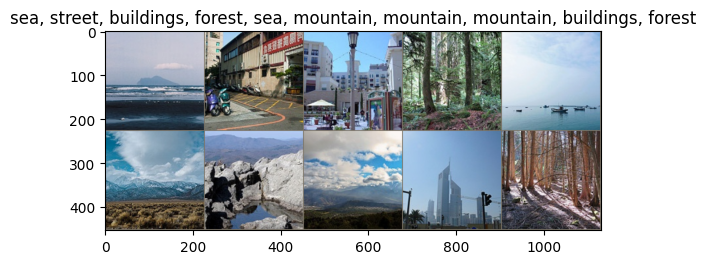

In [12]:
imshow(make_grid(images[:10], nrow=5), labels[:10], class_names)

### Insights about the classes

In [13]:
# print(f"Amount of classes: {len(class_names)}")
# print(f"Classes: {class_names}")
# print(f"Size of training dataset: {len(image_datasets['train'])}")
# print(f"Size of test dataset: {len(image_datasets['test'])}")
# # print(f"Size of validation dataset: {len(val_dataset)}")

# class_counts = {class_name: 0 for class_name in class_names}
# for label in class_names:
#     class_counts[image_datasets['train'].class_names[label]]+=1

# print("\nDistribution of classes in the training dataset:")
# for class_name, count in class_counts.items():
#     print(f"{class_name}: {count}")

## Develop the architecture for a convolutional neural network (CNN) for image classification

### Baseline Model

In [14]:
class BaselineModel(nn.Module):
    def __init__(self, ):
        super(BaselineModel, self).__init__()
        self.num_channels = 32
        
        self.conv1 = nn.Conv2d(3, self.num_channels, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(self.num_channels, self.num_channels*2, 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(self.num_channels*2, self.num_channels*4, 3, stride=1, padding=1)
        
        self.num_features = self._get_num_features()
        
#         self.fc1 = nn.Linear(8*8*self.num_channels*4, self.num_channels*4)
        self.fc1 = nn.Linear(self.num_features, self.num_channels*4)
        self.fc2 = nn.Linear(self.num_channels*4, 6)
        
    def _get_num_features(self):
        dummy_input = torch.zeros(1, 3, 224, 224)
        output = self._forward_conv_layers(dummy_input)
        num_features = output.view(1, -1).size(1)
        return num_features
    
    def _forward_conv_layers(self, x):
#         x = self.conv1(x)
        x = F.relu(F.max_pool2d(x, 2))
#         x = self.conv2(x)
        x = F.relu(F.max_pool2d(x, 2))
#         x = self.conv3(x)
        x = F.relu(F.max_pool2d(x, 2))
        return x
        
    def forward(self, s):
        s = self._forward_conv_layers(s)
        
        s = s.view(s.size(0), -1)
        
        s = F.relu(self.fc1(s))
        s = self.fc2(s)
        
        return F.log_softmax(s, dim=1)

In [15]:
cuda = torch.cuda.is_available()

torch.manual_seed(42)
if cuda:
    torch.cuda.manual_seed(42)

device = 'cuda' if cuda else None

In [16]:
model = BaselineModel().to(device)
    
# # loading the existing model
# # model.load_state_dict(torch.load(path_to_model_file))


optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss().to(device)

# train_losses = []
# train_accs = []

# test_losses = []
# test_accs = []

num_epochs = 15

In [17]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
# num_ftrs = model_ft.fc.in_features
# # Here the size of each output sample is set to 2.
# # Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
# model_ft.fc = nn.Linear(num_ftrs, 2)

num_ftrs = model_ft.fc.in_features  # This gets the size of the final feature map
model_ft.fc = nn.Linear(num_ftrs, len(class_names))  # Adjust for your dataset

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=1e-05)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 168MB/s] 


In [18]:
model

BaselineModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2352, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)

In [19]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Train the model on the training dataset

In [20]:
def train_model(model, criterion, optimizer, num_epochs=25):# scheduler, num_epochs=25):
    since = time.time()
    
    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'test']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'test' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

                if phase == 'train':
                    train_losses.append(epoch_loss)
                    train_accs.append(epoch_acc.item())
                else:
                    test_losses.append(epoch_loss)
                    test_accs.append(epoch_acc.item())
                    
            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
        
    return model, train_losses, train_accs, test_losses, test_accs

In [21]:
model, train_losses, train_accs, test_losses, test_accs = train_model(model, criterion, optimizer, num_epochs=15)

Epoch 1/15
----------
train Loss: 1.6252 Acc: 0.3633
test Loss: 1.5159 Acc: 0.4377

Epoch 2/15
----------
train Loss: 1.4542 Acc: 0.4644
test Loss: 1.4330 Acc: 0.4563

Epoch 3/15
----------
train Loss: 1.3897 Acc: 0.4890
test Loss: 1.3955 Acc: 0.4697

Epoch 4/15
----------
train Loss: 1.3526 Acc: 0.5010
test Loss: 1.3687 Acc: 0.4857

Epoch 5/15
----------
train Loss: 1.3283 Acc: 0.5127
test Loss: 1.3553 Acc: 0.4880

Epoch 6/15
----------
train Loss: 1.3079 Acc: 0.5186
test Loss: 1.3361 Acc: 0.5063

Epoch 7/15
----------
train Loss: 1.2910 Acc: 0.5247
test Loss: 1.3238 Acc: 0.5107

Epoch 8/15
----------
train Loss: 1.2758 Acc: 0.5310
test Loss: 1.3153 Acc: 0.5027

Epoch 9/15
----------
train Loss: 1.2637 Acc: 0.5339
test Loss: 1.3004 Acc: 0.5160

Epoch 10/15
----------
train Loss: 1.2511 Acc: 0.5380
test Loss: 1.2934 Acc: 0.5150

Epoch 11/15
----------
train Loss: 1.2416 Acc: 0.5403
test Loss: 1.2831 Acc: 0.5173

Epoch 12/15
----------
train Loss: 1.2324 Acc: 0.5445
test Loss: 1.2764 Ac

In [22]:
train_losses

[1.6251976592292368,
 1.4542104623350676,
 1.3896825324780617,
 1.3526198941111582,
 1.328334746629879,
 1.3079319110840189,
 1.2910372599485815,
 1.2757987178967212,
 1.263747131516999,
 1.2510761428596253,
 1.2416219450018422,
 1.2323670646684606,
 1.2232092260481948,
 1.2143557424369966,
 1.2075603082510622]

In [23]:
train_accs

[0.36333190822288725,
 0.46437223884851075,
 0.4889553940430383,
 0.5009975773122417,
 0.5126834829699302,
 0.5185976913210774,
 0.5247256662391335,
 0.5309961522017956,
 0.5339176286162177,
 0.5379791933874875,
 0.5403306256234858,
 0.5444634459170585,
 0.5450334900954824,
 0.5523015533703862,
 0.5532278751603249]

In [24]:
torch.save(model.state_dict(), path_to_model_file)
print(f"Model saved to {path_to_model_file}")

Model saved to /kaggle/working/baseline_model.pth


In [25]:
torch.cuda.empty_cache()

In [26]:
model_ft, train_losses, train_accs, test_losses, test_accs  = train_model(model_ft, criterion, optimizer_ft, num_epochs=15)

Epoch 1/15
----------
train Loss: 0.5076 Acc: 0.8474
test Loss: 0.2359 Acc: 0.9207

Epoch 2/15
----------
train Loss: 0.2305 Acc: 0.9244
test Loss: 0.1910 Acc: 0.9327

Epoch 3/15
----------
train Loss: 0.1818 Acc: 0.9413
test Loss: 0.1819 Acc: 0.9363

Epoch 4/15
----------
train Loss: 0.1542 Acc: 0.9493
test Loss: 0.1694 Acc: 0.9393

Epoch 5/15
----------
train Loss: 0.1283 Acc: 0.9587
test Loss: 0.1652 Acc: 0.9403

Epoch 6/15
----------
train Loss: 0.1056 Acc: 0.9686
test Loss: 0.1680 Acc: 0.9390

Epoch 7/15
----------
train Loss: 0.0817 Acc: 0.9768
test Loss: 0.1653 Acc: 0.9430

Epoch 8/15
----------
train Loss: 0.0696 Acc: 0.9810
test Loss: 0.1741 Acc: 0.9403

Epoch 9/15
----------
train Loss: 0.0535 Acc: 0.9868
test Loss: 0.1729 Acc: 0.9410

Epoch 10/15
----------
train Loss: 0.0405 Acc: 0.9905
test Loss: 0.1816 Acc: 0.9400

Epoch 11/15
----------
train Loss: 0.0362 Acc: 0.9912
test Loss: 0.1917 Acc: 0.9363

Epoch 12/15
----------
train Loss: 0.0286 Acc: 0.9936
test Loss: 0.1887 Ac

In [27]:
pretrained_model_filename = 'pretrained_model.pth'
path_to_pretrained_model_file = os.path.join(path_to_model, pretrained_model_filename)

torch.save(model_ft.state_dict(), path_to_pretrained_model_file)
print(f"Model saved to {path_to_pretrained_model_file}")

Model saved to /kaggle/working/pretrained_model.pth


In [28]:
# for epoch in tqdm(range(num_epochs)):
    
#     # train step
    
#     model.train()
    
#     train_epoch_loss = []
#     train_epoch_acc = []
    
#     for i, (train_batch, labels_batch) in tqdm(enumerate(dataloaders['train']), disable=True):
#         if cuda:
#             train_batch, labels_batch = train_batch.cuda(non_blocking = True), labels_batch.cuda(non_blocking=True)
            
#         output_batch = model(train_batch)
        
#         loss = criterion(output_batch, labels_batch)
        
#         optimizer.zero_grad()
#         loss.backward()
        
#         optimizer.step()
        
#         batch_loss = loss.cpu().detach().numpy()
#         batch_acc = balanced_accuracy_score(np.argmax(output_batch.cpu().detach().numpy(), axis=1),
#                                            labels_batch.cpu().detach().numpy())
        
#         train_epoch_loss.append(batch_loss)
#         train_epoch_acc.append(batch_acc)
        
#     print(f'Train epoch [{epoch+1}/{num_epochs}], Loss: {np.mean(train_epoch_loss):.4f}, Acc: {np.mean(train_epoch_acc)}')
#     train_accs.append(np.mean(train_epoch_acc))
#     train_losses.append(np.mean(train_epoch_loss))
        
#     # eval step
    
#     model.eval()
    
#     test_epoch_loss = []
#     test_epoch_acc = []
    
#     with torch.no_grad():
#         for i , (test_batch, labels_batch) in enumerate(dataloaders['test']):
#             if cuda:
#                 test_batch, labels_batch = test_batch.cuda(non_blocking=True), labels_batch.cuda(non_blocking=True)
                
#             output_batch = model(test_batch)
            
#             loss = criterion(output_batch, labels_batch)
            
#             batch_loss = loss.cpu().detach().numpy()
#             batch_acc = balanced_accuracy_score(np.argmax(output_batch.cpu().detach().numpy(), axis=1),
#                                                labels_batch.cpu().detach().numpy())
            
#             test_epoch_loss.append(batch_loss)
#             test_epoch_acc.append(batch_acc)
            
#     print(f'Test Epoch [{epoch+1}/{num_epochs}], Loss: {np.mean(test_epoch_loss):.4f}, Acc: {np.mean(test_epoch_acc)}')
#     test_accs.append(np.mean(test_epoch_acc))
#     test_losses.append(np.mean(test_epoch_loss))

In [29]:
# torch.save(model.state_dict(), path_to_model_file)
# print(f"Model saved to {path_to_model_file}")

## Analyze the effectiveness of the model using the valid and test datasets

In [30]:
def visualize_predictions(model, dataloader, class_names, num_images=5):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size(0)):
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    plt.tight_layout()
                    plt.show()
                    return

                images_so_far += 1
                ax = plt.subplot(num_images//2 + 1, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {class_names[preds[j]]}\nTrue: {class_names[labels[j]]}')

                # Денормалізація зображення для відображення
                inv_normalize = transforms.Normalize(
                    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
                    std=[1/0.229, 1/0.224, 1/0.225]
                )
                inp = inv_normalize(inputs.cpu()[j]).numpy().transpose((1, 2, 0))
                inp = np.clip(inp, 0, 1)

                plt.imshow(inp)

    model.train(mode=was_training)
    plt.tight_layout()
    plt.show()

In [31]:
def plot_training_metrics(train_losses, train_accuracies, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [32]:
# model.load_state_dict(torch.load('baseline_model.pth'))
# model.eval()

# correct = 0
# total = 0
# all_preds = []
# all_labels = []

# with torch.no_grad():
#     for inputs, labels in test_dataloader:
#         inputs, labels = inputs.to(device), labels.to(device)
#         outputs = model(inputs)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()
#         all_preds.extend(predicted.cpu().numpy())
#         all_labels.extend(labels.cpu().numpy())

In [33]:
# model.load_state_dict(torch.load('baseline_model.pth'))
# model.eval()

# correct = 0
# total = 0
# all_preds = []
# all_labels = []

# with torch.no_grad():
#     for inputs, labels in dataloaders['test']:
#         inputs, labels = inputs.to(device), labels.to(device)
#         outputs = model(inputs)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()
#         all_preds.extend(predicted.cpu().numpy())
#         all_labels.extend(labels.cpu().numpy())

In [34]:
# model_ft.load_state_dict(torch.load('pretrained_model.pth'))
# model_ft.eval()

# correct = 0
# total = 0
# all_preds = []
# all_labels = []

# with torch.no_grad():
#     for inputs, labels in dataloaders['test']:
#         inputs, labels = inputs.to(device), labels.to(device)
#         outputs = model_ft(inputs)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()
#         all_preds.extend(predicted.cpu().numpy())
#         all_labels.extend(labels.cpu().numpy())

In [35]:
# class_names = class_names

# # Обчислення точності та F1
# test_accuracy = correct / total
# f1 = f1_score(all_labels, all_preds, average='weighted')

# print(f'Test Accuracy: {test_accuracy:.4f}')
# print(f'F1 Score: {f1:.4f}')

# # Створення матриці помилок
# cm = confusion_matrix(all_labels, all_preds)
# plt.figure(figsize=(10,8))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#             xticklabels=class_names, yticklabels=class_names)
# plt.title('Confusion Matrix')
# plt.ylabel('True label')
# plt.xlabel('Predicted label')
# plt.show()

In [36]:
# class_names = train_dataset.class_names

# # Обчислення точності та F1
# test_accuracy = correct / total
# f1 = f1_score(all_labels, all_preds, average='weighted')

# print(f'Test Accuracy: {test_accuracy:.4f}')
# print(f'F1 Score: {f1:.4f}')

# # Створення матриці помилок
# cm = confusion_matrix(all_labels, all_preds)
# plt.figure(figsize=(10,8))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#             xticklabels=class_names, yticklabels=class_names)
# plt.title('Confusion Matrix')
# plt.ylabel('True label')
# plt.xlabel('Predicted label')
# plt.show()

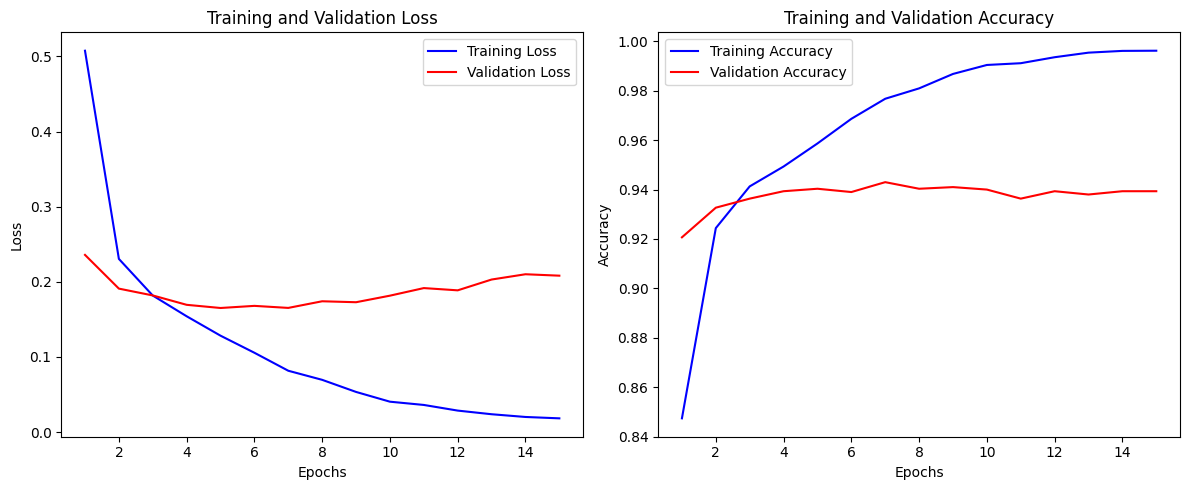

In [37]:
plot_training_metrics(train_losses, train_accs, test_losses, test_accs)

In [38]:
# visualize_predictions(model, test_dataloader, test_dataset.class_names, 10)

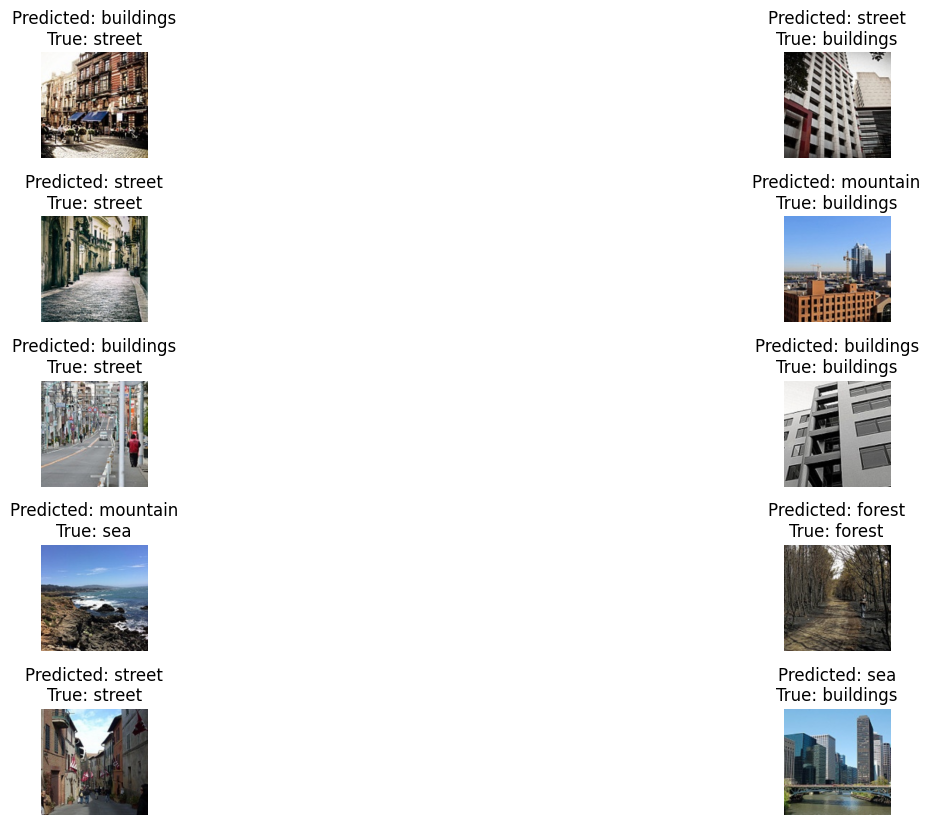

In [39]:
visualize_predictions(model, dataloaders['test'], class_names, 10)

In [40]:
# # %% Function to evaluate the model on the test dataset
# def evaluate_model(model):
#     model.eval()  # Set the model to evaluation mode
#     y_true = []
#     y_pred = []

#     with torch.no_grad():
#         for inputs, labels in test_dataloader:
#             inputs = inputs.to(device)
#             labels = labels.to(device)
#             outputs = model(inputs)
#             _, preds = torch.max(outputs, 1)
#             y_true.extend(labels.cpu().numpy())
#             y_pred.extend(preds.cpu().numpy())

#     return y_true, y_pred

# # Get predictions and true labels for test data
# y_true, y_pred = evaluate_model(model)

# # Calculate F1-score and print classification report
# f1 = f1_score(y_true, y_pred, average='weighted')
# print(f'F1-score (weighted): {f1:.4f}')

# # Classification report
# print(classification_report(y_true, y_pred, target_names=class_names))

In [41]:
def evaluate_model(model):
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    return y_true, y_pred

# Get predictions and true labels for test data
y_true, y_pred = evaluate_model(model)

# Calculate F1-score and print classification report
f1 = f1_score(y_true, y_pred, average='weighted')
print(f'F1-score (weighted): {f1:.4f}')

# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))

F1-score (weighted): 0.5220
              precision    recall  f1-score   support

   buildings       0.38      0.48      0.43       437
      forest       0.78      0.64      0.70       474
     glacier       0.53      0.64      0.58       553
    mountain       0.53      0.66      0.59       525
         sea       0.40      0.18      0.25       510
      street       0.57      0.58      0.58       501

    accuracy                           0.53      3000
   macro avg       0.53      0.53      0.52      3000
weighted avg       0.53      0.53      0.52      3000



## Analysis of a pretrained model

In [42]:
# torch.cuda.empty_cache()

In [43]:
# model_pretrained = models.resnet18(pretrained=True)

# for param in model_pretrained.parameters():
#     param.requires_grad = False
    
# num_ftrs = model_pretrained.fc.in_features
# model_pretrained.fc = nn.Linear(num_ftrs, 2) 

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model_pretrained = model_pretrained.to(device)

In [44]:
# model_pretrained

In [45]:
# optimizer = torch.optim.Adam(model_pretrained.parameters(), lr=0.01)
# criterion = nn.CrossEntropyLoss().to(device)

# train_losses = []
# train_accs = []

# test_losses = []
# test_accs = []

# num_epochs = 15

# for epoch in tqdm(range(num_epochs)):
    
#     # train step
    
#     model_pretrained.train()
    
#     train_epoch_loss = []
#     train_epoch_acc = []
    
#     for i, (train_batch, labels_batch) in tqdm(enumerate(train_dataloader), disable=True):
#         if cuda:
#             train_batch, labels_batch = train_batch.cuda(non_blocking = True), labels_batch.cuda(non_blocking=True)
            
#         output_batch = model_pretrained(train_batch)
        
#         loss = criterion(output_batch, labels_batch)
        
#         optimizer.zero_grad()
#         loss.backward()
        
#         optimizer.step()
        
#         batch_loss = loss.cpu().detach().numpy()
#         batch_acc = balanced_accuracy_score(np.argmax(output_batch.cpu().detach().numpy(), axis=1),
#                                            labels_batch.cpu().detach().numpy())
        
#         train_epoch_loss.append(batch_loss)
#         train_epoch_acc.append(batch_acc)
        
#     print(f'Train epoch [{epoch+1}/{num_epochs}], Loss: {np.mean(train_epoch_loss):.4f}, Acc: {np.mean(train_epoch_acc)}')
#     train_accs.append(np.mean(train_epoch_acc))
#     train_losses.append(np.mean(train_epoch_loss))
        
#     # eval step
    
#     model_pretrained.eval()
    
#     test_epoch_loss = []
#     test_epoch_acc = []
    
#     with torch.no_grad():
#         for i , (test_batch, labels_batch) in enumerate(test_dataloader):
#             if cuda:
#                 test_batch, labels_batch = test_batch.cuda(non_blocking=True), labels_batch.cuda(non_blocking=True)
                
#             output_batch = model_pretrained(test_batch)
            
#             loss = criterion(output_batch, labels_batch)
            
#             batch_loss = loss.cpu().detach().numpy()
#             batch_acc = balanced_accuracy_score(np.argmax(output_batch.cpu().detach().numpy(), axis=1),
#                                                labels_batch.cpu().detach().numpy())
            
#             test_epoch_loss.append(batch_loss)
#             test_epoch_acc.append(batch_acc)
            
#     print(f'Test Epoch [{epoch+1}/{num_epochs}], Loss: {np.mean(test_epoch_loss):.4f}, Acc: {np.mean(test_epoch_acc)}')
#     test_accs.append(np.mean(test_epoch_acc))
#     test_losses.append(np.mean(test_epoch_loss))

In [46]:
# pretrained_model_filename = 'pretrained_model.pth'
# path_to_pretrained_model_file = os.path.join(path_to_model, pretrained_model_filename)

# torch.save(model_pretrained.state_dict(), path_to_pretrained_model_file)
# print(f"Model saved to {path_to_pretrained_model_file}")

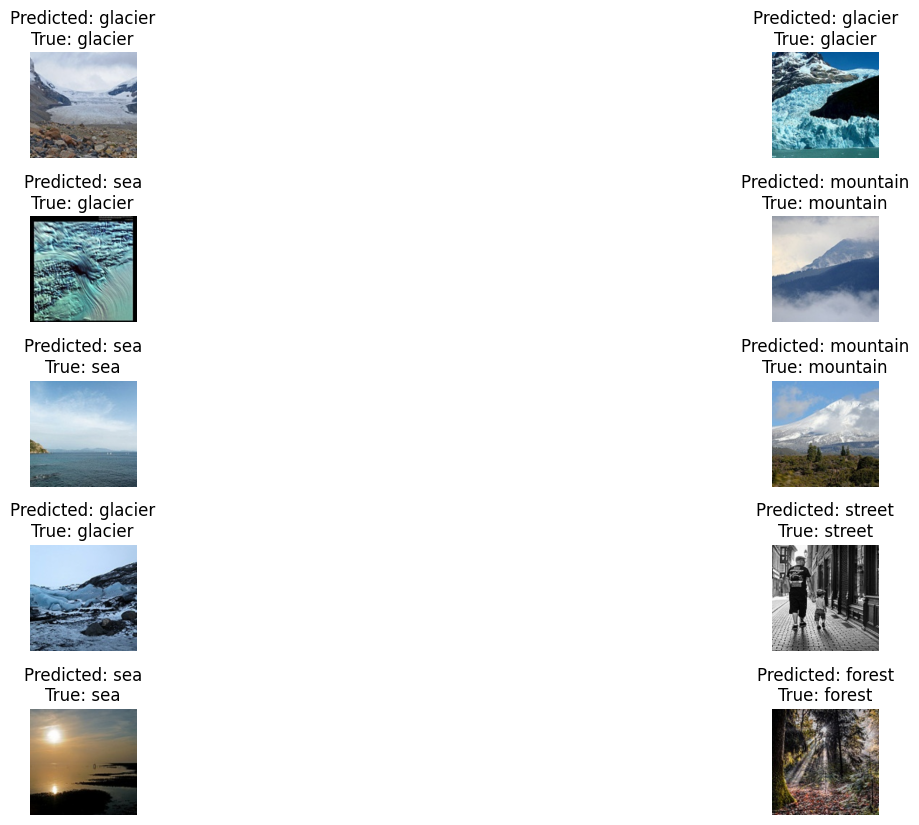

In [47]:
visualize_predictions(model_ft, dataloaders['test'], class_names, 10)

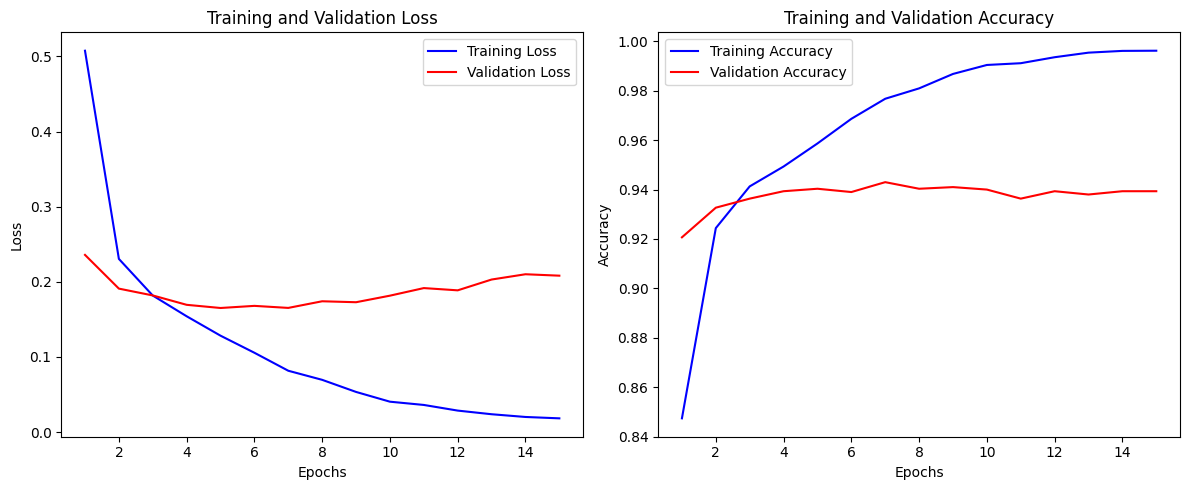

In [48]:
plot_training_metrics(train_losses, train_accs, test_losses, test_accs)

In [49]:
def evaluate_model(model):
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    return y_true, y_pred

# Get predictions and true labels for test data
y_true, y_pred = evaluate_model(model_ft)

# Calculate F1-score and print classification report
f1 = f1_score(y_true, y_pred, average='weighted')
print(f'F1-score (weighted): {f1:.4f}')

# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))

F1-score (weighted): 0.9429
              precision    recall  f1-score   support

   buildings       0.95      0.92      0.93       437
      forest       0.99      1.00      0.99       474
     glacier       0.93      0.88      0.90       553
    mountain       0.89      0.92      0.91       525
         sea       0.97      0.99      0.98       510
      street       0.93      0.96      0.95       501

    accuracy                           0.94      3000
   macro avg       0.94      0.94      0.94      3000
weighted avg       0.94      0.94      0.94      3000



## Analyze the results and proposal of further potential improvements of the model

After the initial run of the custom model, even during the state of training the model it was clearly evident that the model was overfitting as the model was improving its performance on the train dataset while slowly getting worse on the test dataset. However upon checking the results using a classification_report of the results of evaluating the model using the test dataset it showed an accuracy and F1 score of 83%.

Followining this I decided to also test a transfer model using the resnet18 model. For this I tried to train the model on a similar 15epochs to the custom model and found that the model was not training properly. The resulting model performance was unsatisfactory as at the hyperparameter levels of an Adam optimiser with a learning rate of 1e-3, and I increased the number of epochs to 100 at the same learning rate. These changes did not seem to have much of an impact as the Learning Loss and Accuracy were both oscillating around 1.9 and 17-19% respectively. Following this I attempted to change the learning rate to be 0.01 in order to have the model be more flexible in traversing the data while training in order to better learn and exit potential local minimums, however, once again the results were similarly oscilating in the same ranges. Following ths I decided to change the 

